In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.insert(1, "/global/u1/r/rmastand/non-resonant-AD-extrapolation")
from helpers.process_data import morph_mc

In [2]:
n_bins = 40 # for plotting
sample_size = 5 # num. background files to load in

samples_path = "/global/cfs/cdirs/m3246/kbai/HV_samples/"

signal_sample_paths = {"rinv13_4TeV":f"{samples_path}/sig_samples/rinv13_pTmin200GeV.txt",
                       "rinv13_2TeV":f"{samples_path}/sig_samples/rinv13_2TeV_200GeV.txt",
                       "rinv13_3TeV":f"{samples_path}/sig_samples/rinv13_3TeV_300GeV.txt",
                       "rinv0_4TeV":f"{samples_path}/old_analysis_input/rinv0_pTmin200GeV.txt",
                       "rinv23_4TeV":f"{samples_path}/old_analysis_input/rinv23_pTmin200GeV.txt",
                      }

bkg_dir = f"{samples_path}/qcd_data_samples/" 
mc_dir = f"{samples_path}/qcd_mc_samples/" 

save_dir = "../plots/"
os.makedirs(save_dir, exist_ok = True)

## Helpers and nice naming

In [3]:
var_names = ["ht", "met", "m_jj", "tau21_j1", "tau21_j2", "tau32_j1", "tau32_j2"]

def name_map():
    return {
        "m_jj": "$m_{{\\rm jj}}$",
        "met": "MET",
        "ht": "$H_{{\\rm T}}$",
        "pT_j1": "Leading jet $p_{{\\rm T}}$",
        "pT_j2": "Sub-leading jet $p_{{\\rm T}}$",
        "tau21_j1": "Leading jet $\\tau_2/\\tau_1$",
        "tau21_j2": "Sub-leading jet $\\tau_2/\\tau_1$",
        "tau32_j1": "Leading jet $\\tau_3/\\tau_2$",
        "tau32_j2": "Sub-leading jet $\\tau_3/\\tau_2$",
        "min_dPhi": "min$\\Delta\\phi(\\rm j_i, \\rm MET)$",
    }

def unit_map():
    return {
        "m_jj": "(GeV)",
        "met": "(GeV)",
        "ht": "(GeV)",
        "pT_j1": "(GeV)",
        "pT_j2": "(GeV)",
        "tau21_j1": "",
        "tau21_j2": "",
        "tau32_j1": "",
        "tau32_j2": "",
        "min_dPhi": "",
    }


names = name_map()
units = unit_map()

bins_list = []
xlabel_list = []


for x in var_names:
    xlabel_list.append(f"{names[x]} {units[x]}")
    if "tau" in x:
        bins = np.linspace(0, 1, n_bins)
    elif x=="met":
        bins = np.linspace(0, 600, n_bins)
    elif x=="ht":
        bins = np.linspace(0, 4000, n_bins)
    elif x=="m_jj":
        bins = np.linspace(0, 4000, n_bins)
    bins_list.append(bins)


def load_samples(file):
    samples = np.loadtxt(file, dtype=str)
    # Get the names of all varibles
    variables = samples[0]
    # Get the events ordered by varibles
    events = np.asfarray(samples[1:])
    return variables, events


def sort_event_arr(names, variables, events):
    event_list = []
    for x in names:   
        ind_x = ind(variables, x)
        event_list.append(events[:, ind_x])
    return np.stack(event_list, axis=1)


def get_quality_events(arr):
    if np.isnan(arr).any():
        return arr[~np.isnan(arr).any(axis=1)]
    else:
        return arr
    
def ind(variables, name):
    return np.where(variables == name)[0][0]

## Load in data

In [4]:
# define sample size as the number of files

# load signal first

sig_events = {}

for sig_id in signal_sample_paths.keys():

    variables, loc_sig = load_samples(signal_sample_paths[sig_id])
    loc_sig = get_quality_events(loc_sig)
    sig_events[sig_id] = sort_event_arr(var_names, variables, loc_sig)
    
print(sig_events.keys())

dict_keys(['rinv13_4TeV', 'rinv13_2TeV', 'rinv13_3TeV', 'rinv0_4TeV', 'rinv23_4TeV'])


In [5]:
bkg_events_list = []
mc_events_list = []

print(f"Loading {sample_size} samples...")

for i in range(sample_size):

    bkg_path = f"{bkg_dir}/qcd_{i}.txt"
    if os.path.isfile(bkg_path):
        # Load input events ordered by varibles
        _, bkg_i = load_samples(bkg_path)
        bkg_i = get_quality_events(bkg_i)
        bkg_events_list.append(sort_event_arr(var_names, variables, bkg_i))

        
    mc_path = f"{mc_dir}/qcd_{i}.txt"
    if os.path.isfile(mc_path):
        # Load input events ordered by varibles
        _, mc_i = load_samples(mc_path)
        mc_i = get_quality_events(mc_i)
        mc_events_list.append(sort_event_arr(var_names, variables,mc_i))

        
if len(bkg_events_list)==0:
    print("No files loaded.")

Loading 5 samples...


In [6]:
bkg_events = np.concatenate(bkg_events_list)
mc_events = np.concatenate(mc_events_list)
morphed_mc_events = morph_mc(mc_events)

## Plotting helpers

In [35]:
HT_cut = 800    # In SR, HT > 800 GeV
MET_cut = 75
    
    
def plot_all_variables(sig_list, bkg_list, mc_list, xlabels, bins_list=[], labels=["sig", "bkg"], 
                       name="sig_vs_bkg", title="", xlabel="x", outdir="./", 
                       plot_context_bounds = False, *args, **kwargs):
    csig1 = 'coral'
    csig2 = 'orange'
    csig3 = 'blue'
    cbkg = 'lightblue'
    cmc = 'green'

    N = len(sig_list[0])
    
    if N==len(xlabels):
        fig, ax1 = plt.subplots(1, N, figsize=(5*N,5))
        ax1[0].set_ylabel("a.u.", fontsize = 24)
        for i in range(N):
           
            bins = bins_list[i]
            ax1[i].hist(sig_list[0][i], bins = bins, density = True, histtype='step', ls= "-", color=csig1, label=labels[0], lw=3)
            #ax1[i].hist(sig_list[1][i], bins = bins, density = True, histtype='step', ls= "-", color=csig2, label=labels[1], lw=2)
            #ax1[i].hist(sig_list[2][i], bins = bins, density = True, histtype='step', ls= "-", color=csig3, label=labels[2], lw=2)
            ax1[i].hist(bkg_list[i], bins = bins, density = True, histtype='stepfilled', ls= "-", color=cbkg, alpha=1, label=labels[3])
            ax1[i].hist(mc_list[i], bins = bins, density = True, histtype='step', ls= "-", color=cmc, alpha=1, label=labels[4], lw = 2)
            ax1[i].set_xlabel(xlabels[i], fontsize = 24)
            ax1[i].set_yticks([])
            if i == 0:
                ax1[i].legend(fontsize = 16.5, frameon = False)
                
        if plot_context_bounds:
            ax1[0].axvline(HT_cut, color = "k", linestyle = "dashed")
            ax1[1].axvline(MET_cut, color = "k", linestyle = "dashed")
    
        plt.subplots_adjust(wspace=.0, hspace=0)
        plot_name = f"{outdir}/{name}.pdf"
        plt.savefig(plot_name.replace(" ", "_"))
        plt.show
        
        
        plt.close
    else:
        print("Wrong input lists!")

In [36]:
sig_labels_rinv =  {"rinv13_4TeV":r"$Z' \to jj$, $r_{\rm inv} = 1/3$",
                "rinv0_4TeV":r"$Z' \to jj$, $r_{\rm inv} = 0$",
                "rinv23_4TeV":r"$Z' \to jj$, $r_{\rm inv} = 2/3$",
                      }

sig_labels_TeV =  {"rinv13_4TeV":r"$Z' \to jj$, $M_{Z'}$ = 4 TeV",
                "rinv13_2TeV":r"$Z' \to jj$, $M_{Z'}$ = 2 TeV",
                "rinv13_3TeV":r"$Z' \to jj$, $M_{Z'}$ = 3 TeV",
               
                      }

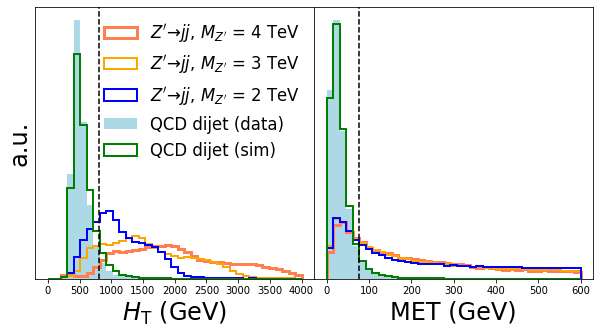

In [39]:
sig_id_to_plot = ['rinv13_4TeV', 'rinv13_3TeV', 'rinv13_2TeV']



# Plot context varibles
sig_list = []
sig_labels = []
for sig_id in sig_id_to_plot:
    sig_list.append(sig_events[sig_id][:, :2].T)
    sig_labels.append(sig_labels_TeV[sig_id])

bkg_list = bkg_events[:, :2].T
mc_list = mc_events[:, :2].T
morphed_mc_list = morphed_mc_events[:, :2].T
xlabels = xlabel_list[:2]
bins = bins_list[:2]

labels=sig_labels + ["QCD dijet (data)", "QCD dijet (sim)"]

# Signal vs background
plot_kwargs = {"bins_list":bins, "name":f"sig_vs_bkg_cont", "labels":labels, "title":"Signal vs background in SR", "outdir":save_dir}
plot_all_variables(sig_list, bkg_list, mc_list, xlabels, plot_context_bounds = True, **plot_kwargs)

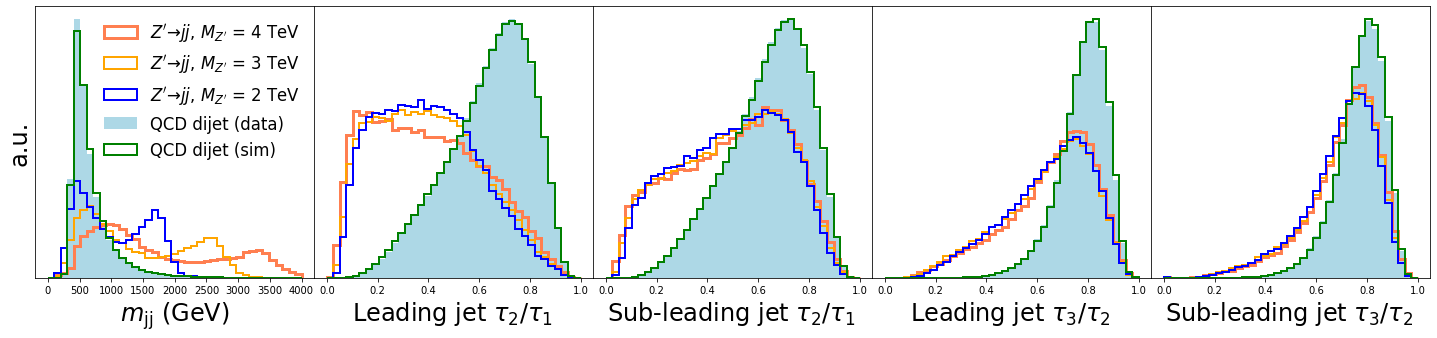

In [42]:
sig_list = []
sig_labels = []
for sig_id in sig_id_to_plot:
    sig_list.append(sig_events[sig_id][:, 2:].T)
    sig_labels.append(sig_labels_TeV[sig_id])
    
bkg_list = bkg_events[:, 2:].T
mc_list = mc_events[:, 2:].T
morphed_mc_list = morphed_mc_events[:, 2:].T
xlabels = xlabel_list[2:]
bins = bins_list[2:]

# Signal vs background
plot_kwargs = {"bins_list":bins, "name":f"sig_vs_bkg_feat", "labels":labels, "title":"Signal vs background in SR", "outdir":save_dir}
plot_all_variables(sig_list, bkg_list, mc_list, xlabels, **plot_kwargs)

## Plot mJJ only

<function matplotlib.pyplot.close(fig=None)>

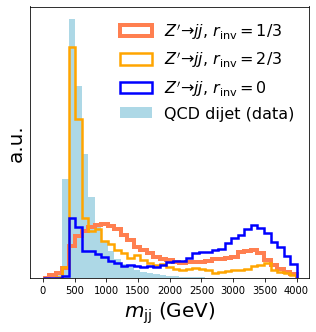

In [14]:
# Plot mjj

sig_id_to_plot = ['rinv13_4TeV', 'rinv23_4TeV', 'rinv0_4TeV']

# Plot context varibles
sig_list = []
sig_labels = []
for sig_id in sig_id_to_plot:
    sig_list.append(sig_events[sig_id][:, 2].T)
    sig_labels.append(sig_labels_rinv[sig_id])
    
bkg_list = bkg_events[:,2]
xlabels = xlabel_list[2]
bins = bins_list[2]
# Signal vs background

labels=sig_labels + ["QCD dijet (data)", "QCD dijet (sim)"]


csig1 = 'coral'
csig2 = 'orange'
csig3 = 'blue'
cbkg = 'lightblue'
cmc = 'green'

fig, ax1 = plt.subplots(1, 1, figsize=(5,5))

ax1.set_ylabel("a.u.", fontsize = 20)

ax1.hist(sig_list[0], bins = bins, density = True, histtype='step', ls= "-", color=csig1, label=labels[0], lw=4)
ax1.hist(sig_list[1], bins = bins, density = True, histtype='step', ls= "-", color=csig2, label=labels[1], lw=2.5)
ax1.hist(sig_list[2], bins = bins, density = True, histtype='step', ls= "-", color=csig3, label=labels[2], lw=2.5)
ax1.hist(bkg_list, bins = bins, density = True, histtype='stepfilled', ls= "-", color=cbkg, alpha=1, label=labels[3])
ax1.set_xlabel(xlabels, fontsize = 20)
ax1.set_yticks([])
ax1.legend(fontsize = 16, frameon = False)
plt.subplots_adjust(wspace=.0, hspace=0)
plot_name = f"{save_dir}/mjj_scan.pdf"
plt.savefig(plot_name.replace(" ", "_"))
plt.show


plt.close
